## Train Onet on rendered images

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("..")

In [2]:
args = {
    'config': 'configs/encoder/augmented.yaml',
    'no_cuda': True,
    'exit_after': -1
}

In [3]:
import torch
import torch.optim as optim
from tensorboardX import SummaryWriter
import numpy as np
import os
import argparse
import time
import matplotlib; matplotlib.use('Agg')
from im2mesh import config, data
from im2mesh.checkpoints import CheckpointIO

/home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
cfg = config.load_config(args["config"], 'configs/default.yaml')
is_cuda = (torch.cuda.is_available() and not args["no_cuda"])
device = torch.device("cuda" if is_cuda else "cpu")

In [5]:
# Shorthands
out_dir = cfg['training']['out_dir']
batch_size = cfg['training']['batch_size']
backup_every = cfg['training']['backup_every']
exit_after = args["exit_after"]

In [6]:
model_selection_metric = cfg['training']['model_selection_metric']
if cfg['training']['model_selection_mode'] == 'maximize':
    model_selection_sign = 1
elif cfg['training']['model_selection_mode'] == 'minimize':
    model_selection_sign = -1
else:
    raise ValueError('model_selection_mode must be '
                     'either maximize or minimize.')

In [7]:
# Output directory
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [8]:
cfg

{'method': 'autoencoder',
 'data': {'dataset': 'Shapes3D',
  'path': 'data/ShapeNet',
  'classes': None,
  'input_type': 'img',
  'train_split': 'train',
  'val_split': 'val',
  'test_split': 'test',
  'dim': 3,
  'points_file': 'points.npz',
  'points_iou_file': 'points.npz',
  'points_subsample': 2048,
  'points_unpackbits': True,
  'model_file': 'model.off',
  'watertight_file': 'model_watertight.off',
  'img_folder': 'img_phuc2019',
  'img_size': 224,
  'img_with_camera': False,
  'img_augment': True,
  'img_ext': 'png',
  'bg_augment': 1.0,
  'scale_limit': 0.2,
  'n_views': 24,
  'pointcloud_file': 'pointcloud.npz',
  'pointcloud_chamfer_file': 'pointcloud.npz',
  'pointcloud_n': 256,
  'pointcloud_target_n': 1024,
  'pointcloud_noise': 0.05,
  'voxels_file': 'model.binvox',
  'with_transforms': False,
  'with_gt': True,
  'bg_folder': 'data/indoor_images'},
 'model': {'decoder': 'simple',
  'encoder': 'resnet18',
  'encoder_latent': None,
  'decoder_kwargs': {},
  'encoder_kwarg

In [9]:
# Dataset
train_dataset = config.get_dataset('train', cfg)
val_dataset = config.get_dataset('val', cfg)

### Train

In [10]:
import matplotlib.pyplot as plt
from torchvision.transforms import transforms

In [11]:
len(train_dataset)

30811

#### Train input

In [12]:
sample = train_dataset[np.random.randint(0, len(train_dataset))]

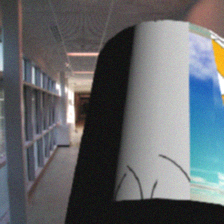

In [16]:
transforms.ToPILImage()(sample['inputs'])

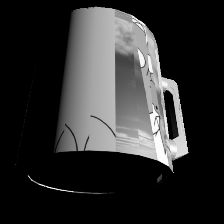

In [14]:
transforms.ToPILImage()(sample['inputs.gt'])

In [15]:
sample.get('inputs.gt').min()

tensor(0.)

### Data loader

In [17]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=4, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn)

In [18]:
batch = next(iter(train_loader))

In [19]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, num_workers=4, shuffle=False,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn
)

In [20]:
vis_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=12, shuffle=True,
    collate_fn=data.collate_remove_none,
    worker_init_fn=data.worker_init_fn,
)

In [21]:
data = next(iter(vis_loader))

### Model

In [22]:
model = config.get_model(cfg, device=device, dataset=train_dataset)

In [23]:
optimizer = config.get_optimizer(model, cfg)

In [24]:
checkpoint_io = CheckpointIO(out_dir, model=model, optimizer=optimizer)

In [25]:
logger = SummaryWriter(os.path.join(out_dir, 'logs'))

In [26]:
trainer = config.get_trainer(model, optimizer, logger, cfg, device=device)

In [27]:
trainer.train_step(batch)

0.23948630690574646

In [28]:
trainer.visualize(data)

100%|██████████| 12/12 [00:00<00:00, 14.17it/s]


In [36]:
%debug

> /home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tensorboardX/summary.py(58)_calc_scale_factor()
     56 
     57 def _calc_scale_factor(tensor):
---> 58     converted = tensor.numpy() if not isinstance(tensor, np.ndarray) else tensor
     59     return 1 if converted.dtype == np.uint8 else 255
     60 



ipdb>  u


> /home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tensorboardX/summary.py(202)image()
    200     tensor = make_np(tensor, 'IMG')
    201     # Do not assume that user passes in values in [0, 255], use data type to detect
--> 202     scale_factor = _calc_scale_factor(tensor)
    203     tensor = tensor.astype(np.float32)
    204     tensor = (tensor * scale_factor).astype(np.uint8)



ipdb>  tensor
ipdb>  u


> /home/phuc/miniconda3/envs/mesh_funcspace/lib/python3.6/site-packages/tensorboardX/writer.py(412)add_image()
    410         if self._check_caffe2(img_tensor):
    411             img_tensor = workspace.FetchBlob(img_tensor)
--> 412         self.file_writer.add_summary(image(tag, img_tensor), global_step, walltime)
    413 
    414     def add_image_with_boxes(self, tag, img_tensor, box_tensor, global_step=None,



ipdb>  img_tensor


<PIL.Image.Image image mode=RGB size=224x224 at 0x7F96E06A5198>


ipdb>  exit
